In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']
    
    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }
    
    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }
    
    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [21]:
pip install psycopg2-binary

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
import pickle
from catboost import CatBoostClassifier
import pandas as pd
from sqlalchemy import create_engine

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH

def load_models():
    from_file = CatBoostClassifier()
    # LOAD MODEL HERE PLS :)
    loaded_model = from_file.load_model(get_model_path("catboost_model"))
    return loaded_model

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [23]:
feed_data_limit = 500000
user_data_limit = 163205#114903 163205
post_text_limit = 7023#6924 7023

In [24]:
%%time
from sklearn.decomposition import PCA 
user_data = batch_load_sql(f"SELECT * FROM public.user_data LIMIT {user_data_limit}")
user_data = user_data.iloc[user_data.drop('user_id', axis=1).drop_duplicates().index.tolist()]

CPU times: user 941 ms, sys: 78.8 ms, total: 1.02 s
Wall time: 7.13 s


In [25]:
from category_encoders import BinaryEncoder

one_hot_columns = ['gender', 'os', 'exp_group', 'source']
dummies = pd.get_dummies(user_data[one_hot_columns].astype(object))
user_data[dummies.columns.to_list()] = dummies


binary_encoder = BinaryEncoder(cols=['age', 'city'])
new_data = binary_encoder.fit_transform(user_data[['age', 'city']])
user_data = pd.concat([user_data, new_data], axis = 1)

user_data = user_data.drop(['gender', 'exp_group', 'os', 'source', 'country', 'city', 'age'], axis=1)
user_data

,user_id,gender_0,gender_1,os_Android,os_iOS,exp_group_0,exp_group_1,exp_group_2,exp_group_3,exp_group_4,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,200,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,201,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,202,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,203,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,204,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163197,168545,0,1,0,1,0,0,0,0,1,...,0,0,1,0,1,1,1,1,1,1
163198,168546,0,1,1,0,0,0,0,0,1,...,1,1,0,0,1,1,0,0,0,0
163200,168548,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,0
163202,168550,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0


In [26]:
%%time
post_text = batch_load_sql(f"SELECT * FROM public.post_text_df LIMIT {post_text_limit}")
post_text = post_text.iloc[post_text.drop('post_id', axis=1).drop_duplicates().index.tolist()].dropna()

CPU times: user 50.2 ms, sys: 13.9 ms, total: 64.1 ms
Wall time: 4.91 s


In [27]:
from category_encoders import BinaryEncoder

one_hot_columns = ['topic'] 
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object)) 
post_text[dummies.columns.to_list()] = dummies

In [28]:
from transformers import BertTokenizer
tokenizer, model = get_model('bert')
max_length = 200
embeddings = torch.empty(max_length, 1)
for index,row in post_text.iterrows():
    encoding = tokenizer.encode_plus(row['text'], add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', truncation=True, max_length=max_length,padding='max_length')
    embeddings = torch.cat((embeddings, encoding['input_ids'][0].unsqueeze(1)), 1)

embedding = pd.DataFrame(StandardScaler().fit_transform(embeddings)).T.iloc[1:]
embedding.index = post_text.index
post_text = pd.concat([embedding, post_text], axis=1).drop('text', axis=1)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
post_text

,0,1,2,3,4,5,6,7,8,9,...,199,post_id,topic,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,-0.676732,-0.272409,0.197092,0.316551,-0.365369,1.660946,-0.461321,-0.272409,0.554615,0.218676,...,-0.676518,1,business,1,0,0,0,0,0,0
1,-0.666208,2.555736,-0.452255,-0.454573,0.267387,-0.371522,1.449082,4.010405,2.038454,2.166615,...,-0.665997,2,business,1,0,0,0,0,0,0
2,-0.758669,-0.198330,-0.743002,0.460989,-0.336572,0.129394,-0.457487,0.350212,-0.748532,3.407745,...,-0.758485,3,business,1,0,0,0,0,0,0
3,-0.647267,-0.380707,-0.411218,0.339578,0.181283,-0.481262,-0.341830,-0.638245,3.060619,-0.480770,...,-0.647103,4,business,1,0,0,0,0,0,0
4,-0.704088,3.595880,3.142748,-0.402000,-0.161630,-0.125718,-0.520562,-0.425280,-0.178051,1.904622,...,-0.703908,5,business,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,-0.586961,1.989130,-0.583144,-0.576226,-0.335269,-0.340040,0.619016,0.062668,-0.570500,3.509305,...,-0.611057,7315,movie,0,0,0,1,0,0,0
7019,-0.593553,-0.581865,-0.188635,-0.323175,0.035512,-0.587839,0.143819,2.522421,-0.289410,-0.333045,...,-0.619786,7316,movie,0,0,0,1,0,0,0
7020,-0.546717,-0.537280,-0.322737,-0.315397,-0.136087,-0.328399,-0.300926,-0.335530,-0.117422,-0.335949,...,-0.567899,7317,movie,0,0,0,1,0,0,0
7021,-0.553606,-0.285047,-0.132118,-0.541616,-0.184604,-0.286379,-0.276255,-0.241353,-0.285314,-0.286646,...,-0.580515,7318,movie,0,0,0,1,0,0,0


#test
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(post_text['text'])

tfidf_tokens = vectorizer.get_feature_names_out()

post_text['tf_idf'] = pd.DataFrame(
    data=X.toarray(), 
    index=[i for i in range(X.shape[0])], 
    columns=tfidf_tokens
).sum(axis=1)

from category_encoders import BinaryEncoder

one_hot_columns = ['topic']
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object))
post_text[dummies.columns.to_list()] = dummies

from sklearn.preprocessing import StandardScaler

post_text = post_text.dropna().drop('topic', axis=1)

scaler = StandardScaler()
scaler.fit(post_text['tf_idf'].to_frame())
post_text['tf_idf'] = scaler.transform(post_text['tf_idf'].to_frame())

In [30]:
post_text

,0,1,2,3,4,5,6,7,8,9,...,199,post_id,topic,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,-0.676732,-0.272409,0.197092,0.316551,-0.365369,1.660946,-0.461321,-0.272409,0.554615,0.218676,...,-0.676518,1,business,1,0,0,0,0,0,0
1,-0.666208,2.555736,-0.452255,-0.454573,0.267387,-0.371522,1.449082,4.010405,2.038454,2.166615,...,-0.665997,2,business,1,0,0,0,0,0,0
2,-0.758669,-0.198330,-0.743002,0.460989,-0.336572,0.129394,-0.457487,0.350212,-0.748532,3.407745,...,-0.758485,3,business,1,0,0,0,0,0,0
3,-0.647267,-0.380707,-0.411218,0.339578,0.181283,-0.481262,-0.341830,-0.638245,3.060619,-0.480770,...,-0.647103,4,business,1,0,0,0,0,0,0
4,-0.704088,3.595880,3.142748,-0.402000,-0.161630,-0.125718,-0.520562,-0.425280,-0.178051,1.904622,...,-0.703908,5,business,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,-0.586961,1.989130,-0.583144,-0.576226,-0.335269,-0.340040,0.619016,0.062668,-0.570500,3.509305,...,-0.611057,7315,movie,0,0,0,1,0,0,0
7019,-0.593553,-0.581865,-0.188635,-0.323175,0.035512,-0.587839,0.143819,2.522421,-0.289410,-0.333045,...,-0.619786,7316,movie,0,0,0,1,0,0,0
7020,-0.546717,-0.537280,-0.322737,-0.315397,-0.136087,-0.328399,-0.300926,-0.335530,-0.117422,-0.335949,...,-0.567899,7317,movie,0,0,0,1,0,0,0
7021,-0.553606,-0.285047,-0.132118,-0.541616,-0.184604,-0.286379,-0.276255,-0.241353,-0.285314,-0.286646,...,-0.580515,7318,movie,0,0,0,1,0,0,0


In [31]:
%%time
feed_data = batch_load_sql(f"SELECT * FROM public.feed_data LIMIT {feed_data_limit}")

feed_data

CPU times: user 1.79 s, sys: 98.1 ms, total: 1.89 s
Wall time: 12.3 s


,timestamp,user_id,post_id,action,target
0,2021-11-04 07:43:15,68803,2673,view,0
1,2021-11-04 07:43:27,68803,5085,view,0
2,2021-11-04 07:44:52,68803,4971,view,0
3,2021-11-04 07:47:01,68803,6982,view,0
4,2021-11-04 07:49:02,68803,3040,view,0
...,...,...,...,...,...
499995,2021-12-13 13:40:05,69122,6521,view,0
499996,2021-12-13 13:40:28,69122,4428,view,0
499997,2021-12-13 13:41:24,69122,6038,view,1
499998,2021-12-13 13:41:55,69122,6038,like,0


In [32]:
df = post_text.merge(feed_data, how='inner', on='post_id').merge(user_data, how='inner', on='user_id').drop_duplicates()
#pred = feed_data.merge(user_data, how='inner', on='user_id')
#df = post_text.merge(pred, how='inner', on='post_id' )
#user_data_limit = 25000
#post_data_limit = 400

#df = post_text[:post_data_limit].merge(user_data[:user_data_limit], how='cross').merge(feed_data, how='inner', on=['user_id', 'post_id'])

In [33]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [34]:
df_copy = df.copy()
df_copy

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,-0.676732,-0.272409,0.197092,0.316551,-0.365369,1.660946,-0.461321,-0.272409,0.554615,0.218676,...,0,1,0,0,1,0,1,0,1,0
1,-0.663038,0.014030,-0.177582,-0.366738,-0.473126,-0.432309,0.292378,-0.455174,-0.473504,0.339052,...,0,1,0,0,1,0,1,0,1,0
2,-0.627594,-0.257460,0.720653,-0.230278,2.690245,-0.397676,2.001851,-0.284643,2.505178,-0.624876,...,0,1,0,0,1,0,1,0,1,0
3,-0.694516,1.910159,-0.533853,0.995718,-0.527605,1.577527,2.155318,-0.544563,-0.464678,-0.042789,...,0,1,0,0,1,0,1,0,1,0
4,-0.186983,0.317316,0.425594,2.429577,0.240158,0.564564,0.245274,0.270851,0.243142,0.249963,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342505,-0.676973,-0.488613,-0.665016,0.288740,0.668752,-0.489479,0.857459,2.111343,-0.473884,0.109911,...,0,0,0,1,0,0,0,0,0,0
342506,-0.380092,0.311727,1.595692,0.459974,-0.097917,-0.088933,-0.360719,2.587655,-0.098479,0.089637,...,0,0,0,1,0,0,0,0,0,0
342507,-0.380092,0.311727,1.595692,0.459974,-0.097917,-0.088933,-0.360719,2.587655,-0.098479,0.089637,...,0,0,0,1,0,0,0,0,0,0
342508,-0.586961,1.989130,-0.583144,-0.576226,-0.335269,-0.340040,0.619016,0.062668,-0.570500,3.509305,...,0,0,0,1,0,0,0,0,0,0


In [35]:
df_copy.drop(['timestamp', 'target', 'action', 'post_id', 'user_id'], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,-0.676732,-0.272409,0.197092,0.316551,-0.365369,1.660946,-0.461321,-0.272409,0.554615,0.218676,...,0,1,0,0,1,0,1,0,1,0
1,-0.663038,0.014030,-0.177582,-0.366738,-0.473126,-0.432309,0.292378,-0.455174,-0.473504,0.339052,...,0,1,0,0,1,0,1,0,1,0
2,-0.627594,-0.257460,0.720653,-0.230278,2.690245,-0.397676,2.001851,-0.284643,2.505178,-0.624876,...,0,1,0,0,1,0,1,0,1,0
3,-0.694516,1.910159,-0.533853,0.995718,-0.527605,1.577527,2.155318,-0.544563,-0.464678,-0.042789,...,0,1,0,0,1,0,1,0,1,0
4,-0.186983,0.317316,0.425594,2.429577,0.240158,0.564564,0.245274,0.270851,0.243142,0.249963,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342505,-0.676973,-0.488613,-0.665016,0.288740,0.668752,-0.489479,0.857459,2.111343,-0.473884,0.109911,...,0,0,0,1,0,0,0,0,0,0
342506,-0.380092,0.311727,1.595692,0.459974,-0.097917,-0.088933,-0.360719,2.587655,-0.098479,0.089637,...,0,0,0,1,0,0,0,0,0,0
342507,-0.380092,0.311727,1.595692,0.459974,-0.097917,-0.088933,-0.360719,2.587655,-0.098479,0.089637,...,0,0,0,1,0,0,0,0,0,0
342508,-0.586961,1.989130,-0.583144,-0.576226,-0.335269,-0.340040,0.619016,0.062668,-0.570500,3.509305,...,0,0,0,1,0,0,0,0,0,0


In [42]:
from torch.utils.data import Dataset
df_to_dataset = df_copy.drop(['timestamp', 'action', 'post_id', 'user_id', 'topic'], axis=1)
df_to_dataset

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,-0.676732,-0.272409,0.197092,0.316551,-0.365369,1.660946,-0.461321,-0.272409,0.554615,0.218676,...,0,1,0,0,1,0,1,0,1,0
1,-0.663038,0.014030,-0.177582,-0.366738,-0.473126,-0.432309,0.292378,-0.455174,-0.473504,0.339052,...,0,1,0,0,1,0,1,0,1,0
2,-0.627594,-0.257460,0.720653,-0.230278,2.690245,-0.397676,2.001851,-0.284643,2.505178,-0.624876,...,0,1,0,0,1,0,1,0,1,0
3,-0.694516,1.910159,-0.533853,0.995718,-0.527605,1.577527,2.155318,-0.544563,-0.464678,-0.042789,...,0,1,0,0,1,0,1,0,1,0
4,-0.186983,0.317316,0.425594,2.429577,0.240158,0.564564,0.245274,0.270851,0.243142,0.249963,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342505,-0.676973,-0.488613,-0.665016,0.288740,0.668752,-0.489479,0.857459,2.111343,-0.473884,0.109911,...,0,0,0,1,0,0,0,0,0,0
342506,-0.380092,0.311727,1.595692,0.459974,-0.097917,-0.088933,-0.360719,2.587655,-0.098479,0.089637,...,0,0,0,1,0,0,0,0,0,0
342507,-0.380092,0.311727,1.595692,0.459974,-0.097917,-0.088933,-0.360719,2.587655,-0.098479,0.089637,...,0,0,0,1,0,0,0,0,0,0
342508,-0.586961,1.989130,-0.583144,-0.576226,-0.335269,-0.340040,0.619016,0.062668,-0.570500,3.509305,...,0,0,0,1,0,0,0,0,0,0


In [43]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.labels = torch.tensor(df[['target']].to_numpy().reshape(-1)).float()
        #self.labels = torch.full((df.shape[0], 6924), 0.5)
        self.dataset = torch.tensor(df.drop('target', axis=1).values).float()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx] 

In [44]:
dataset = CustomDataset(df_to_dataset)
dataset.__getitem__(3649)[0].shape

torch.Size([237])

In [45]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.dropout = nn.Sequential(
            nn.Dropout(p=0.2)
        )
        self.block1 = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(64, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Linear(128, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Linear(128, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.block5 = nn.Sequential(
            nn.Linear(256, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.block6 = nn.Sequential(
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.block7 = nn.Sequential(
            nn.Linear(512, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        #self.block8 = nn.Sequential(
        #    nn.Linear(4096, 8192), 
        #    nn.BatchNorm1d(8192),
        #    nn.ReLU()
        #)
        #self.block9 = nn.Sequential(
        #    nn.Linear(8192, 8192), 
        #    nn.BatchNorm1d(8192),
        #    nn.ReLU()
        #)
        self.block8 = nn.Sequential(
            nn.Linear(512, 1),
            #nn.Softmax(dim=1)
            #nn.Sigmoid()
            nn.Tanh()
        )

    def forward(self, x):
        output = self.block1(x)
        output = self.block2(output)
        output = self.dropout(output)
        output = self.block3(output) + output
        output = self.dropout(output)
        output = self.block4(output)
        output = self.dropout(output)
        output = self.block5(output) + output
        output = self.dropout(output)
        output = self.block6(output)
        output = self.dropout(output)
        output = self.block7(output) + output
        output = self.dropout(output)
        output = self.block8(output)
        #output = self.dropout(output)
        #output = self.block9(output) + output
        #output = self.dropout(output)
        #output = self.block10(output)
        

        return output

In [46]:
#!g1.1
from tqdm import tqdm


def train(model, train_loader) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        optimizer.zero_grad()

        output = model(x.float())
        
        
        
        loss = loss_fn(output, y)
        
        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        
        total += y.size(0)
        correct += (output == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [47]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        
        output = model(x.float())
        loss = loss_fn(output, y)

        total_loss += loss.item()

        #_, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (output == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [48]:
#!g1.1
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    #plt.figure(figsize=(16, 8))

    #plt.title(title + ' accuracy')
    
    #plt.plot(train_accuracy, label='Train accuracy')
    #plt.plot(valid_accuracy, label='Valid accuracy')
    #plt.legend()
    #plt.grid()

    #plt.show()

In [49]:
def whole_train_valid_cycle(model, num_epochs, title, train_loader, valid_loader):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

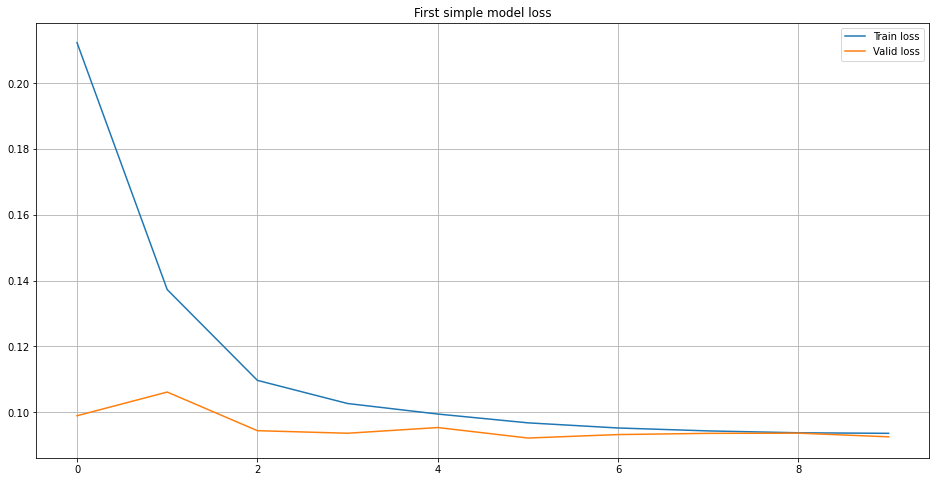

In [50]:
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=8192, shuffle=True, num_workers=2, pin_memory=True)


net = Net(df_to_dataset.shape[1] - 1).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_fn = nn.MSELoss() 
#loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(net, 10, 'First simple model', train_loader, valid_loader)

In [51]:
torch.save(net.state_dict(), 'net')